# Exploratory Data Analysis for NBA Lineup Prediction and Hidden Patterns

This notebook organizes the data exploration steps from the raw CSV file and implements several views to uncover hidden patterns. Our goals include:

- **Lineup stability and variation** over time
- **Frequency of player appearances** in different positions (e.g., home_0 to home_4)
- **Outcome analysis** by lineup
- **Common matchups:** identifying which home players appear most frequently against specific away lineups

These insights will help us engineer better features for the predictive model.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options for Pandas
pd.set_option('display.max_columns', None)

## 1. Load and Inspect the Raw Data

In this section, we load the raw CSV file for the 2007 season and inspect its contents.

In [5]:
# Load the 2007 dataset (update the path as needed)
data_path = "../data/matchups-2007.csv"
df2007 = pd.read_csv(data_path)

# Display the first few rows and information about the dataset
print(df2007.head())
print(df2007.info())

           game  season home_team away_team  starting_min  end_min  \
0  200610310LAL    2007       LAL       PHO             0        5   
1  200610310LAL    2007       LAL       PHO             6        7   
2  200610310LAL    2007       LAL       PHO             8        9   
3  200610310LAL    2007       LAL       PHO            10       10   
4  200610310LAL    2007       LAL       PHO            11       11   

         home_0         home_1         home_2         home_3  \
0  Andrew Bynum     Lamar Odom    Luke Walton  Sasha Vujacic   
1  Andrew Bynum     Lamar Odom    Luke Walton  Sasha Vujacic   
2    Lamar Odom    Luke Walton  Maurice Evans   Ronny Turiaf   
3    Lamar Odom    Luke Walton  Maurice Evans   Ronny Turiaf   
4   Luke Walton  Maurice Evans   Ronny Turiaf   Smush Parker   

                home_4             away_0           away_1       away_2  \
0         Smush Parker         Boris Diaw      Kurt Thomas    Raja Bell   
1         Smush Parker  Amar'e Stoudemire  L

## 2. Filter Data and Create a Date Column

We now filter the dataset to include only the allowed features and extract a proper date from the `game` column.

In [6]:
# Define the allowed features
allowed_features = [
    'game', 'season', 'home_team', 'away_team', 'starting_min',
    'home_0', 'home_1', 'home_2', 'home_3', 'home_4',
    'away_0', 'away_1', 'away_2', 'away_3', 'away_4',
    'outcome'
]

# Filter the dataframe and create a copy
df_filtered = df2007[allowed_features].copy()

# Create a date column from the first 8 characters of the 'game' column
df_filtered['date'] = pd.to_datetime(df_filtered['game'].str[:8], format='%Y%m%d')

print(df_filtered.head())

           game  season home_team away_team  starting_min        home_0  \
0  200610310LAL    2007       LAL       PHO             0  Andrew Bynum   
1  200610310LAL    2007       LAL       PHO             6  Andrew Bynum   
2  200610310LAL    2007       LAL       PHO             8    Lamar Odom   
3  200610310LAL    2007       LAL       PHO            10    Lamar Odom   
4  200610310LAL    2007       LAL       PHO            11   Luke Walton   

          home_1         home_2         home_3               home_4  \
0     Lamar Odom    Luke Walton  Sasha Vujacic         Smush Parker   
1     Lamar Odom    Luke Walton  Sasha Vujacic         Smush Parker   
2    Luke Walton  Maurice Evans   Ronny Turiaf         Smush Parker   
3    Luke Walton  Maurice Evans   Ronny Turiaf         Smush Parker   
4  Maurice Evans   Ronny Turiaf   Smush Parker  Vladimir Radmanovic   

              away_0           away_1       away_2           away_3  \
0         Boris Diaw      Kurt Thomas    Raja Bell 

## 3. Create Lineup Tuples for Home and Away Teams

To analyze lineup frequency and uniqueness, we create sorted tuples for both home and away lineups.

In [7]:
# Create lineup tuples (sorted alphabetically for consistency)
df_filtered['home_lineup'] = df_filtered[['home_0', 'home_1', 'home_2', 'home_3', 'home_4']].apply(lambda x: tuple(sorted(x)), axis=1)
df_filtered['away_lineup'] = df_filtered[['away_0', 'away_1', 'away_2', 'away_3', 'away_4']].apply(lambda x: tuple(sorted(x)), axis=1)

print(df_filtered[['game', 'home_lineup', 'away_lineup', 'date']].head())

           game                                        home_lineup  \
0  200610310LAL  (Andrew Bynum, Lamar Odom, Luke Walton, Sasha ...   
1  200610310LAL  (Andrew Bynum, Lamar Odom, Luke Walton, Sasha ...   
2  200610310LAL  (Lamar Odom, Luke Walton, Maurice Evans, Ronny...   
3  200610310LAL  (Lamar Odom, Luke Walton, Maurice Evans, Ronny...   
4  200610310LAL  (Luke Walton, Maurice Evans, Ronny Turiaf, Smu...   

                                         away_lineup       date  
0  (Boris Diaw, Kurt Thomas, Raja Bell, Shawn Mar... 2006-10-31  
1  (Amar'e Stoudemire, Leandro Barbosa, Raja Bell... 2006-10-31  
2  (Amar'e Stoudemire, Leandro Barbosa, Raja Bell... 2006-10-31  
3  (Boris Diaw, James Jones, Kurt Thomas, Leandro... 2006-10-31  
4  (Boris Diaw, James Jones, Kurt Thomas, Leandro... 2006-10-31  


## 4. Unique Lineup Counts per Game

Here we group by game and count how many unique home and away lineups were used.

In [8]:
# Count unique lineups per game
lineup_counts = df_filtered.groupby('game').agg(
    unique_home_lineups=('home_lineup', 'nunique'),
    unique_away_lineups=('away_lineup', 'nunique')
).reset_index()

print(lineup_counts.head())

           game  unique_home_lineups  unique_away_lineups
0  200610310LAL                   11                    9
1  200610310MIA                   11                   16
2  200611010BOS                   19                   17
3  200611010CHA                   16                   15
4  200611010CLE                   12                   10


## 5. Most Frequently Used Lineups per Game

We now identify the most frequently used home and away lineups for each game.

In [9]:
# Count occurrences of each lineup combination
lineup_usage = df_filtered.groupby(['game', 'home_team', 'away_team', 'date', 'home_lineup', 'away_lineup']).size().reset_index(name='count')

# For each game, select the lineup combination with the highest count
most_used_lineups = lineup_usage.sort_values(['game', 'count'], ascending=[True, False]).drop_duplicates('game')

print(most_used_lineups.head())

             game home_team away_team       date  \
2    200610310LAL       LAL       PHO 2006-10-31   
36   200610310MIA       MIA       CHI 2006-10-31   
59   200611010BOS       BOS       NOK 2006-11-01   
72   200611010CHA       CHA       IND 2006-11-01   
115  200611010CLE       CLE       WAS 2006-11-01   

                                           home_lineup  \
2    (Andrew Bynum, Lamar Odom, Luke Walton, Mauric...   
36   (Antoine Walker, Dwyane Wade, Gary Payton, Sha...   
59   (Delonte West, Kendrick Perkins, Paul Pierce, ...   
72   (Adam Morrison, Bernard Robinson, Brevin Knigh...   
115  (Damon Jones, Donyell Marshall, Drew Gooden, L...   

                                           away_lineup  count  
2    (Boris Diaw, Leandro Barbosa, Raja Bell, Shawn...      2  
36   (Ben Gordon, Ben Wallace, Kirk Hinrich, Luol D...      2  
59   (Chris Paul, David West, Desmond Mason, Peja S...      2  
72   (Al Harrington, Danny Granger, Jamaal Tinsley,...      1  
115  (Antonio Dani

## 6. Additional Views and Analyses

In this section we implement several analyses to uncover hidden patterns:

1. **Frequency Analysis by Player Position:** Frequency of players in each home position
2. **Outcome Analysis by Home Lineup:** Average outcome (e.g., win/loss) and number of games per lineup
3. **Common Home Players Against Specific Away Lineups:** Which home players appear most often against each away lineup
4. **Lineup Variation Over Time:** How the number of unique home lineups changes over time

### 6.1 Frequency Analysis by Player Position

We calculate how frequently each player appears in each home position (home_0, home_1, etc.).

In [10]:
# Analyze frequency of players in each home position
for pos in ['home_0', 'home_1', 'home_2', 'home_3', 'home_4']:
    print(f"Frequency for {pos}:")
    print(df_filtered[pos].value_counts().head(10))
    print("---")

Frequency for home_0:
home_0
Allen Iverson        657
Adam Morrison        588
Amar'e Stoudemire    557
Andre Iguodala       553
Chris Wilcox         552
Anderson Varejao     528
Danny Granger        511
Joe Johnson          496
Antawn Jamison       477
Al Jefferson         470
Name: count, dtype: int64
---
Frequency for home_1:
home_1
Mark Blount        450
Eddy Curry         421
Josh Childress     415
Ben Wallace        375
Andre Miller       372
Baron Davis        365
Carmelo Anthony    357
Cuttino Mobley     356
Chris Bosh         340
Kobe Bryant        334
Name: count, dtype: int64
---
Frequency for home_2:
home_2
Lamar Odom         337
Leandro Barbosa    333
Elton Brand        332
Marko Jaric        328
Gerald Wallace     319
Jamal Crawford     312
Kirk Hinrich       310
Erick Dampier      294
Luther Head        293
Kyle Korver        292
Name: count, dtype: int64
---
Frequency for home_3:
home_3
Tim Duncan          503
Shawn Marion        447
Jason Terry         436
Mike Dunleav

### 6.2 Outcome Analysis by Home Lineup

Here we group by both the home team and home lineup to compute the number of games and the average outcome for each lineup.

In [11]:
# Outcome analysis by home lineup with home team information
lineup_outcomes = df_filtered.groupby(['home_team', 'home_lineup']).agg(
    games=('game', 'count'),
    avg_outcome=('outcome', 'mean')
).reset_index()

print(lineup_outcomes.sort_values('games', ascending=False).head(10))

     home_team                                        home_lineup  games  \
3968       MIN  (Kevin Garnett, Mark Blount, Mike James, Ricky...    126   
6684       WAS  (Antawn Jamison, Brendan Haywood, Caron Butler...    108   
6397       UTA  (Andrei Kirilenko, Carlos Boozer, Derek Fisher...    101   
1521       DAL  (Devin Harris, Dirk Nowitzki, Erick Dampier, J...     96   
5218       PHO  (Amar'e Stoudemire, Boris Diaw, Raja Bell, Sha...     94   
1064       CHI  (Ben Gordon, Ben Wallace, Kirk Hinrich, Luol D...     90   
2365       HOU  (Dikembe Mutombo, Juwan Howard, Rafer Alston, ...     84   
5260       PHO  (Amar'e Stoudemire, Leandro Barbosa, Raja Bell...     82   
1953       DET  (Chauncey Billups, Chris Webber, Rasheed Walla...     80   
4921       ORL  (Dwight Howard, Grant Hill, Hedo Turkoglu, Jam...     79   

      avg_outcome  
3968    -0.301587  
6684    -0.111111  
6397    -0.049505  
1521     0.145833  
5218    -0.021277  
1064    -0.177778  
2365    -0.166667  
526

In [12]:
# Optionally, view a larger subset sorted by average outcome
lineup_outcomes.head(35).sort_values('avg_outcome', ascending=False)

,home_team,home_lineup,games,avg_outcome
24,ATL,"(Anthony Johnson, Josh Childress, Marvin Willi...",1,1.000000
15,ATL,"(Anthony Johnson, Josh Childress, Josh Smith, ...",1,1.000000
5,ATL,"(Anthony Johnson, Joe Johnson, Josh Childress,...",2,1.000000
34,ATL,"(Anthony Johnson, Josh Childress, Salim Stouda...",1,1.000000
25,ATL,"(Anthony Johnson, Josh Childress, Marvin Willi...",1,1.000000
20,ATL,"(Anthony Johnson, Josh Childress, Josh Smith, ...",1,1.000000
18,ATL,"(Anthony Johnson, Josh Childress, Josh Smith, ...",4,0.500000
33,ATL,"(Anthony Johnson, Josh Childress, Salim Stouda...",3,0.333333
16,ATL,"(Anthony Johnson, Josh Childress, Josh Smith, ...",41,0.073171
1,ATL,"(Anthony Johnson, Esteban Batista, Marvin Will...",2,0.000000


### 6.3 Most Common Home Players Against Specific Away Lineups

We melt the home player columns to analyze individual player frequencies per away lineup and then sort the results.

In [13]:
# Melt the home player columns to analyze individual player frequency
home_players = df_filtered.melt(
    id_vars=['game', 'away_lineup', 'date'],
    value_vars=['home_0', 'home_1', 'home_2', 'home_3', 'home_4'],
    var_name='home_position',
    value_name='home_player'
)

# Count the frequency of each home player per away lineup
common_players_vs_away = home_players.groupby(['away_lineup', 'home_player']).size().reset_index(name='count')

# Sort the entire DataFrame by away_lineup and descending count
sorted_common_players = common_players_vs_away.sort_values(['away_lineup', 'count'], ascending=[True, False])

# Display the first 35 rows
sorted_common_players.head(35)

,away_lineup,home_player,count
0,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Craig Smith,2
1,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Mark Blount,2
5,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Ricky Davis,2
2,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Marko Jaric,1
3,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Randy Foye,1
4,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Rashad McCants,1
6,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Troy Hudson,1
7,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Andrei Kirilenko,1
8,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Carlos Boozer,1
9,"(Aaron McKie, Andrew Bynum, Brian Cook, Kobe B...",Derek Fisher,1


### 6.4 Lineup Variation Over Time

We merge the unique lineup counts with game dates and examine how the average number of unique home lineups changes over time.

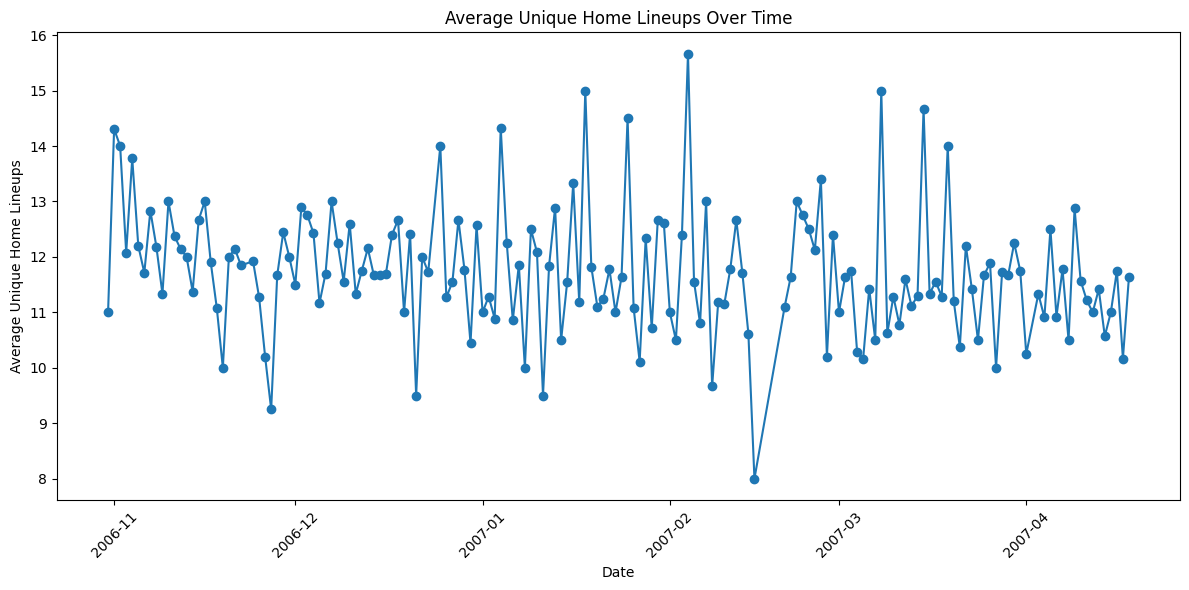

In [14]:
# Merge the lineup_counts with date information (one record per game)
game_dates = df_filtered[['game', 'date']].drop_duplicates()
lineup_counts = lineup_counts.merge(game_dates, on='game', how='left')

# Aggregate the average number of unique home lineups by date
daily_variation = lineup_counts.groupby('date')['unique_home_lineups'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_variation['date'], daily_variation['unique_home_lineups'], marker='o')
plt.title('Average Unique Home Lineups Over Time')
plt.xlabel('Date')
plt.ylabel('Average Unique Home Lineups')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Starting Lineup Analysis

Next, we focus on the starting lineups. We extract, for each game, the row with the smallest `starting_min` (the starting lineup) and then determine:

- The **most common starting lineup** for each home team
- The **most successful starting lineup** (using average outcome as a proxy)

Below we combine these analyses.

In [15]:
# Extract the starting lineup for each game (using the smallest starting_min per game)
starting_lineups = df_filtered.sort_values('starting_min').groupby('game').first().reset_index()

# Compute frequency and average outcome for each starting lineup by home team
starting_lineup_stats = starting_lineups.groupby(['home_team', 'home_lineup']).agg(
    games_count=('game', 'count'),
    avg_outcome=('outcome', 'mean')
).reset_index()

# For each home team, select the most common starting lineup
idx_common = starting_lineup_stats.groupby('home_team')['games_count'].idxmax()
most_common_starting_lineups = starting_lineup_stats.loc[idx_common].reset_index(drop=True)

print("Most Common Starting Lineups:")
print(most_common_starting_lineups.sort_values('games_count', ascending=False))

# For each home team, select the starting lineup with the highest average outcome
# (Optionally filtering out those with very few appearances)
min_games = 5
team_lineup_success = starting_lineup_stats[starting_lineup_stats['games_count'] >= min_games]
idx_success = team_lineup_success.groupby('home_team')['avg_outcome'].idxmax()
most_successful_starting_lineups = team_lineup_success.loc[idx_success].reset_index(drop=True)

print("\nMost Successful Starting Lineups:")
print(most_successful_starting_lineups.sort_values('avg_outcome', ascending=False))

Most Common Starting Lineups:
   home_team                                        home_lineup  games_count  \
16       MIN  (Kevin Garnett, Mark Blount, Mike James, Ricky...           26   
5        DAL  (Devin Harris, Dirk Nowitzki, Erick Dampier, J...           23   
20       ORL  (Dwight Howard, Grant Hill, Hedo Turkoglu, Jam...           23   
22       PHO  (Amar'e Stoudemire, Boris Diaw, Raja Bell, Sha...           22   
3        CHI  (Ben Gordon, Ben Wallace, Kirk Hinrich, Luol D...           20   
28       UTA  (Andrei Kirilenko, Carlos Boozer, Derek Fisher...           19   
9        HOU  (Chuck Hayes, Rafer Alston, Shane Battier, Tra...           17   
7        DET  (Chauncey Billups, Chris Webber, Rasheed Walla...           17   
29       WAS  (Antawn Jamison, Brendan Haywood, Caron Butler...           17   
4        CLE  (Drew Gooden, Eric Snow, Larry Hughes, LeBron ...           15   
18       NOK  (Chris Paul, David West, Desmond Mason, Devin ...           14   
17       N

## 8. Minutes Played Analysis

We now calculate the minutes played by each home player using only the `starting_min` values. In each game, the duration of a lineup segment is calculated as the difference between the current row’s `starting_min` and the next row’s `starting_min`. For the final segment of a game, we use the game length (48 minutes) minus the current `starting_min`. Note that a player may change positions during the game; this approach accounts for that by melting all home lineup columns.

In [16]:
# Sort the DataFrame by game and starting_min
df_sorted = df_filtered.sort_values(['game', 'starting_min']).copy()

# Compute the duration for each lineup segment per game
# For each game, duration = next starting_min - current starting_min
# For the last segment in each game, duration = 48 - current starting_min
df_sorted['duration'] = df_sorted.groupby('game')['starting_min'].transform(lambda x: x.shift(-1) - x)
df_sorted['duration'] = df_sorted['duration'].fillna(48 - df_sorted['starting_min'])

# Melt the home lineup columns so that each row corresponds to a player's appearance in that segment
home_players = df_sorted.melt(
    id_vars=['game', 'home_team', 'duration'],
    value_vars=['home_0', 'home_1', 'home_2', 'home_3', 'home_4'],
    var_name='position',
    value_name='player'
)

# Group by home_team and player to sum the durations (minutes played)
player_minutes = home_players.groupby(['home_team', 'player'])['duration'].sum().reset_index()
player_minutes.rename(columns={'duration': 'total_minutes'}, inplace=True)

# For each team, select the top 5 players by minutes played
top5_by_team = (
    player_minutes.sort_values(['home_team', 'total_minutes'], ascending=[True, False])
    .groupby('home_team')
    .head(5)
    .reset_index(drop=True)
)

print(top5_by_team)

    home_team             player  total_minutes
0         ATL         Josh Smith         1322.0
1         ATL        Joe Johnson         1120.0
2         ATL    Marvin Williams         1107.0
3         ATL     Josh Childress         1077.0
4         ATL      Zaza Pachulia         1034.0
..        ...                ...            ...
145       WAS     Gilbert Arenas         1459.0
146       WAS       Caron Butler         1319.0
147       WAS     Antawn Jamison         1290.0
148       WAS  DeShawn Stevenson         1256.0
149       WAS    Brendan Haywood          890.0

[150 rows x 3 columns]


## 9. Conclusions and Next Steps

We have now organized our exploratory analysis and generated several views:

- **Data Loading and Preparation:** Inspection, filtering, and date extraction
- **Lineup Analysis:** Creation of lineup tuples, counting unique lineups, and identifying the most frequent and successful lineups
- **Additional Views:** Frequency by position, outcome analysis, common matchup analysis, and temporal variation
- **Starting Lineup & Minutes Played:** Analysis of starting lineups and calculation of playing time by aggregating lineup segment durations

These insights will guide further feature engineering—such as adding a "lineup stability" score or incorporating network centrality measures—to improve the accuracy, precision, and recall of our missing-player prediction model.

Next steps might include:

- Deepening the analysis by linking external data (e.g., player positions or roles)
- Applying clustering or association rule mining to detect common player combinations
- Testing different predictive models with the engineered features

Feel free to extend or modify this analysis as needed.